# FordB Challenge Datasets

Description:

This data was originally used in a competition in the IEEE World Congress on Computational Intelligence, 2008. The classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems: For FordB the training data were collected in typical operating conditions, but the test data samples were collected under noisy conditions.

Dataset source: 
* http://timeseriesclassification.com/description.php?Dataset=FordA
* http://timeseriesclassification.com/description.php?Dataset=FordB
* http://home.comcast.net/~nn_classification/ (dead link)

## Data preparation

In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sktime.datatypes import convert_to
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from mcfly.modelgen import generate_models
from mcfly.find_architecture import find_best_architecture
from mcfly.find_architecture import train_models_on_samples

warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(42)
SEED=42

In [2]:
# Load train and test datasets
X_train, y_train = load_from_tsfile("../data/FordB/FordB_TRAIN.ts", return_y=True, return_data_type="numpy3D")

# Swap axes so that Mcfly models can consume the input data
X_train = np.swapaxes(X_train, 1, 2)

X_test, y_test = load_from_tsfile("../data/FordB/FordB_TEST.ts", return_y=True, return_data_type="numpy3D")
X_test = np.swapaxes(X_test, 1, 2)

# Encode labels using OneHotEncoder
ohe = OneHotEncoder()
ohe = ohe.fit(y_train.reshape(-1, 1))

y_train = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test = ohe.transform(y_test.reshape(-1, 1)).toarray()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3636, 500, 1), (810, 500, 1), (3636, 2), (810, 2))

In [3]:
# Validation dataset
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.20, 
    random_state=SEED,
    shuffle=True, 
    stratify=y_train
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2908, 500, 1), (728, 500, 1), (2908, 2), (728, 2))

In [4]:
print("y_train:", Counter(np.argmax(y_train, axis=1)))
print("y_val:", Counter(np.argmax(y_val, axis=1)))
print("y_test:", Counter(np.argmax(y_test, axis=1)))

y_train: Counter({0: 1488, 1: 1420})
y_val: Counter({0: 372, 1: 356})
y_test: Counter({1: 409, 0: 401})


### Class weights

In [5]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y_train, axis=1)),
    y = np.argmax(y_train, axis=1)                                                    
)

class_weights = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))
class_weights

{0: 0.9771505376344086, 1: 1.023943661971831}

## Model training

In [16]:
%%time

file_name = f"model-comparison-20220811.json"
output_file = os.path.join("../data/mcfly-models-fordb", file_name)
model_path = os.path.join("../data/mcfly-models-fordb")

models = generate_models(
    X_train.shape, 
    y_train.shape[1],
    number_of_models=5,
    metrics=["accuracy"],
    model_types=["CNN", "ResNet", "InceptionTime"], # ["InceptionTime"] #
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=X_train.shape[0],
    early_stopping_patience=5,
)

Generated models will be trained on subset of the data (subset size: 2908).
Training model 0 CNN
Epoch 1/30
146/146 [==============================] - 4s 19ms/step - loss: 4.4212 - accuracy: 0.6984 - val_loss: 2.0982 - val_accuracy: 0.4890
Epoch 2/30
146/146 [==============================] - 3s 18ms/step - loss: 1.3008 - accuracy: 0.7923 - val_loss: 1.8029 - val_accuracy: 0.4890
Epoch 3/30
146/146 [==============================] - 3s 18ms/step - loss: 0.7669 - accuracy: 0.8105 - val_loss: 1.8731 - val_accuracy: 0.4890
Epoch 4/30
146/146 [==============================] - 3s 18ms/step - loss: 0.6363 - accuracy: 0.8188 - val_loss: 1.5638 - val_accuracy: 0.5055
Epoch 5/30
146/146 [==============================] - 3s 17ms/step - loss: 0.5625 - accuracy: 0.8246 - val_loss: 0.7439 - val_accuracy: 0.6772
Epoch 6/30
146/146 [==============================] - 3s 18ms/step - loss: 0.5362 - accuracy: 0.8202 - val_loss: 0.5921 - val_accuracy: 0.8187
Epoch 7/30
146/146 [=========================

146/146 [==============================] - 8s 54ms/step - loss: 0.2582 - accuracy: 0.9938 - val_loss: 0.5407 - val_accuracy: 0.8310
Epoch 18/30
146/146 [==============================] - 8s 55ms/step - loss: 0.2509 - accuracy: 0.9959 - val_loss: 0.5281 - val_accuracy: 0.8379
Epoch 19/30
146/146 [==============================] - 8s 55ms/step - loss: 0.2461 - accuracy: 0.9945 - val_loss: 0.5197 - val_accuracy: 0.8475
Epoch 20/30
146/146 [==============================] - 8s 54ms/step - loss: 0.2278 - accuracy: 0.9979 - val_loss: 0.7321 - val_accuracy: 0.7459
Epoch 21/30
146/146 [==============================] - 8s 54ms/step - loss: 0.2149 - accuracy: 0.9983 - val_loss: 0.5846 - val_accuracy: 0.7898
Epoch 22/30
146/146 [==============================] - 8s 55ms/step - loss: 0.2050 - accuracy: 0.9979 - val_loss: 0.7139 - val_accuracy: 0.7239
Epoch 23/30
146/146 [==============================] - 8s 55ms/step - loss: 0.2001 - accuracy: 0.9993 - val_loss: 0.5195 - val_accuracy: 0.8187
Epoc

In [17]:
best_model_index = np.argmax(val_metrics["accuracy"])
best_model, best_params, best_model_type = models[best_model_index]

print("Best model type:", best_model_type)

Best model type: ResNet


### Model training history plots

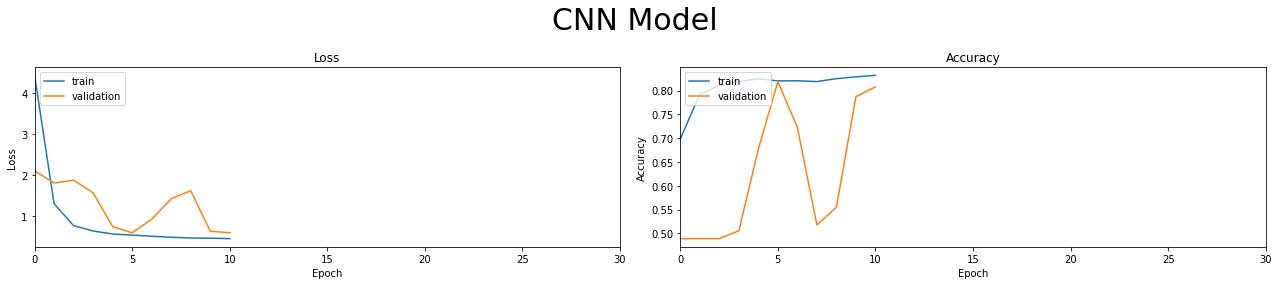

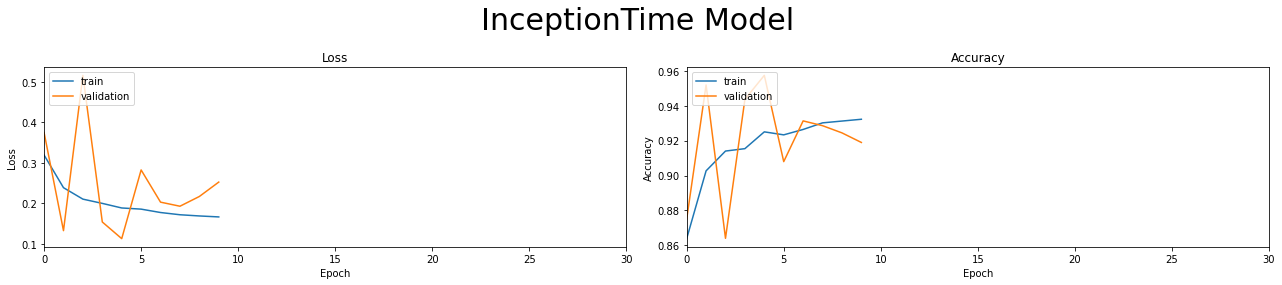

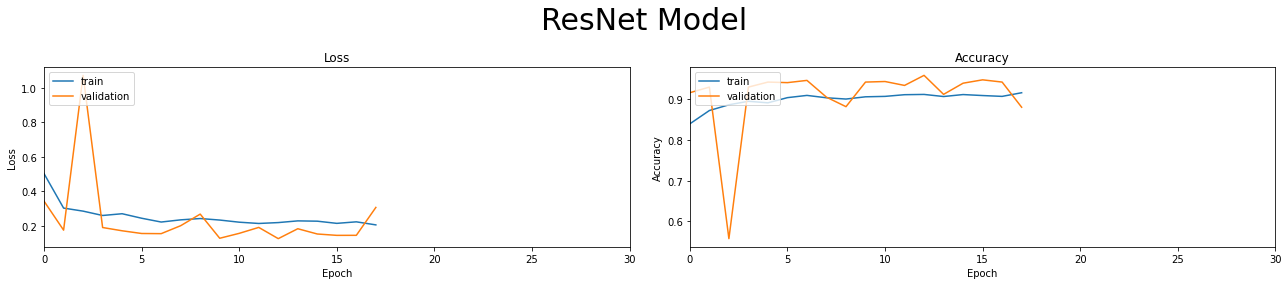

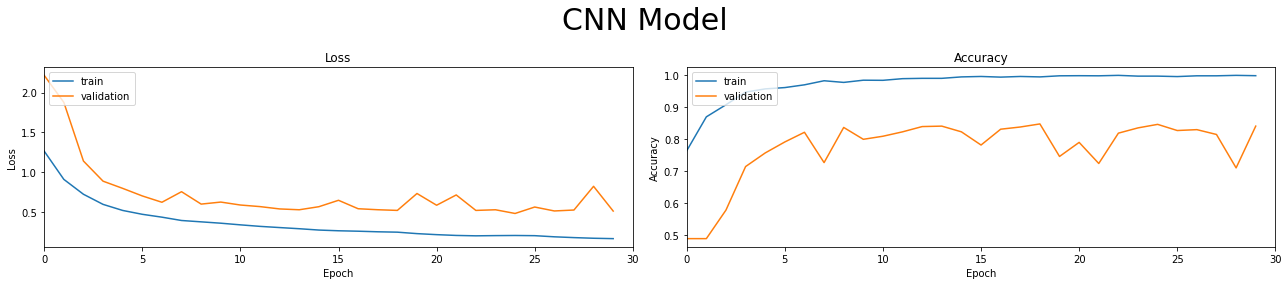

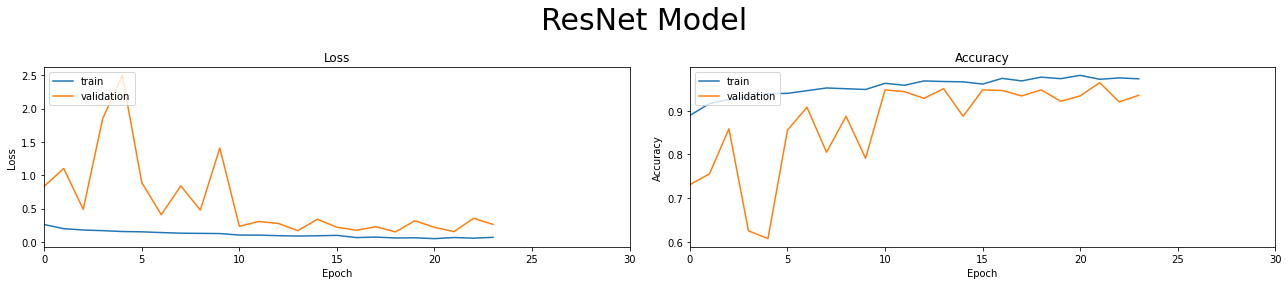

In [19]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['train', 'validation'], loc='upper left')
    ax1.set_xlim([0, 30])

    ax2.plot(history[i].history['accuracy'])
    ax2.plot(history[i].history['val_accuracy'])
    ax2.set_title('Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='upper left')
    ax2.set_xlim([0, 30])

    plt.tight_layout()
    plt.show()

### ResNet model evaluation (the best model)

In [20]:
%%time

y_pred = best_model.predict(X_test, batch_size=1)

810/810 [==============================] - 7s 8ms/step
CPU times: total: 6.28 s
Wall time: 7.18 s


In [21]:
print("Classification report for the ResNet model:\n")
print(classification_report(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1)
))

Classification report for the ResNet model:

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       401
           1       0.87      0.76      0.81       409

    accuracy                           0.82       810
   macro avg       0.83      0.82      0.82       810
weighted avg       0.83      0.82      0.82       810



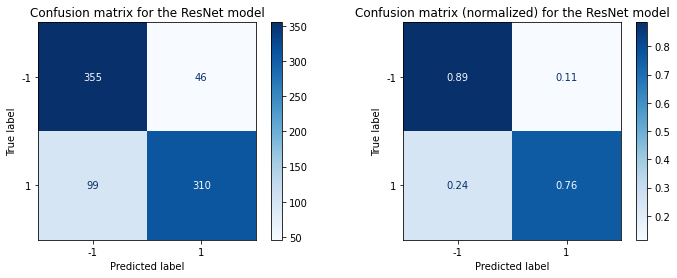

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)
ax1.set_title("Confusion matrix for the ResNet model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1), 
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)
ax2.set_title("Confusion matrix (normalized) for the ResNet model")

plt.show()

In [28]:
%%time

for i in range(len(models)):
    print("------------------------------------------------------------\n")
    model_0, _, model_type = models[i]

    y_pred = model_0.predict(X_test, batch_size=1)
    
    print("Model index:", i)

    print(f"Classification report for the {model_type} model:\n")
    print(classification_report(
        np.argmax(y_test, axis=1), 
        np.argmax(y_pred, axis=1)
    ))

------------------------------------------------------------

810/810 [==============================] - 2s 2ms/step
Model index: 0
Classification report for the CNN model:

              precision    recall  f1-score   support

           0       0.87      0.17      0.28       401
           1       0.55      0.98      0.70       409

    accuracy                           0.58       810
   macro avg       0.71      0.57      0.49       810
weighted avg       0.71      0.58      0.49       810

------------------------------------------------------------

810/810 [==============================] - 6s 7ms/step
Model index: 1
Classification report for the InceptionTime model:

              precision    recall  f1-score   support

           0       0.71      0.91      0.80       401
           1       0.87      0.65      0.74       409

    accuracy                           0.77       810
   macro avg       0.79      0.78      0.77       810
weighted avg       0.80      0.77      0.77